## Libraries

In [1]:
# libraries
import numpy as np
import sys
sys.path.append("../backend/")
import matplotlib.pylab as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import objects
import materials
from stack import *

#parallel
import concurrent.futures
%matplotlib inline


##################################################################
EMUstack is brought to you by Bjorn Sturmberg, Kokou Dossou, 
Felix Lawrence & Lindsay Botton, with support from CUDOS & ARENA
Starting EMUstack calculation ...
##################################################################



## EMUstack: tilted elliptical au nanohole array using the 'custom' target interface
We calculate the Transmission and Reflection spectra of a **tilted elliptical au nanohole array** with pitch **nd_p=400nm**, ellipse major axis **nd_r=300 nm**, height **nd_h=50 nm**, ellipticity **el=0.5** and rotation **theta=Pi/3**.

A few standard targets are included in objects.NanoStruct yet, up to now, it was impossible to add parametrizable unite cells without modifying the EMUStack source code. Now it is possible to pass two additional parameters to objects.NanoStruct: **geo_file** and **geo_params**.

- **geo_file** is the unit cell filename. In this case *ellipse_msh_template.geo* is our example and can be used as a starting point for new targets.
- **geo_params** is a dictionary containing the parameter names and values to be modified in the custom *.geo* file. As an example, if we have a dictionary such as `{'radius':100.0}` we will look inside the *.geo* file for the string `'radius = 0'` and substitute it with the string `'radius = 100.0'`.

In [2]:
# light parameters
wl_1 = 500
wl_2 = 1100
n_wl = 64

# Set up light objects
wavelengths = np.linspace(wl_1,wl_2, n_wl)
light_list  = [objects.Light(wl, max_order_PWs = 3,theta=0.0,phi=0.0) for wl in wavelengths]

# nanodisk array r and pitch in nm
nd_r = 300
nd_p = 400
nd_h = 50
el = 0.5
theta = np.pi/3

# defining the layers: period must be consistent throughout simulation!!!
NHs = objects.NanoStruct('2D_array', nd_p, 
    2.0*nd_r,  # This parameter is ineffective because we use inc_shape='custom'
    height_nm = nd_h,
    inclusion_a = materials.Air, background = materials.Au, loss = True,
    inc_shape='custom',
    plotting_fields=False,plot_real=1,
    geo_file='ellipse_msh_template.geo',  # we use a custom .geo file
    geo_params={'ellipticity':el,'a1':nd_r,'angle':theta},  # we pass custom parameters
    make_mesh_now = True, force_mesh = True, lc_bkg = 0.12, lc2= 5.0, lc3= 1.0,plt_msh=True)

superstrate = objects.ThinFilm(period = nd_p, height_nm = 'semi_inf',
    material = materials.Air, loss = False)
substrate   = objects.ThinFilm(period = nd_p, height_nm = 'semi_inf',
    material = materials.Air, loss = False)

In [3]:
# EMUstack Function
def simulate_stack(light):

    # evaluate each layer individually 
    sim_NHs          = NHs.calc_modes(light)
    sim_superstrate  = superstrate.calc_modes(light)
    sim_substrate    = substrate.calc_modes(light)

    # build the stack solution
    stackSub = Stack((sim_substrate, sim_NHs, sim_superstrate))
    stackSub.calc_scat(pol = 'TM')

    return stackSub

In [4]:
%%time
# computation
with concurrent.futures.ProcessPoolExecutor() as executor:
    stacks_list = list(executor.map(simulate_stack, light_list))

CPU times: user 240 ms, sys: 535 ms, total: 775 ms
Wall time: 1min 33s


# Spectra plot

In [5]:
# spectra
a_list = []
t_list = []
r_list = []
for stack in stacks_list:
    a_list.extend(stack.a_list)
    t_list.extend(stack.t_list)
    r_list.extend(stack.r_list)
layers_steps = len(stacks_list[0].layers) - 1
a_tot      = []
t_tot      = []
r_tot      = []
for i in range(len(wavelengths)):
    a_tot.append(float(a_list[layers_steps-1+(i*layers_steps)]))
    t_tot.append(float(t_list[layers_steps-1+(i*layers_steps)]))
    r_tot.append(float(r_list[i]))

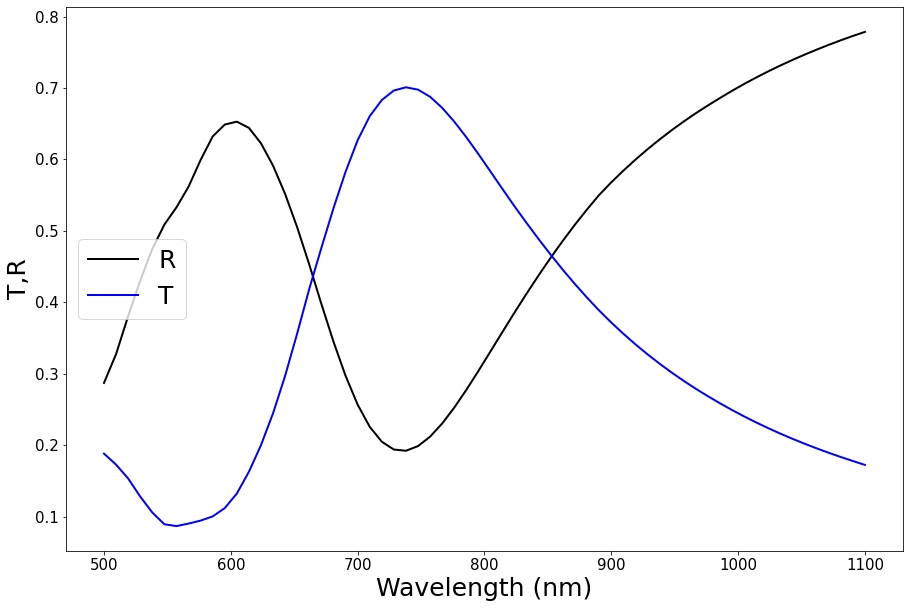

In [6]:
# T and R spectra
plt.figure(figsize=(15,10))
plt.plot(wavelengths,np.array(r_tot),'k',
         wavelengths,np.array(t_tot),'b',linewidth = 2.0);
f_size=25;

# labels
plt.xlabel("Wavelength (nm)",fontsize = f_size);
plt.ylabel("T,R",fontsize = f_size);

# ticks
plt.xticks(fontsize=f_size-10);
plt.yticks(fontsize=f_size-10);

# legend
plt.legend( ["R","T"],fontsize = f_size, loc='center left',fancybox=True);